In [1]:
import numpy as np
import stim
import pymatching
import sinter
import sys

print(f"--- Environment Report ---")
print(f"Python executable: {sys.executable}")
print(f"NumPy version:     {np.__version__}")
print(f"Stim version:      {stim.__version__}")
print(f"Sinter version:    {sinter.__version__}")
print(f"PyMatching version: {pymatching.__version__}")

# This is the test that mimics the error.
# In modern NumPy, this should be True.
test_int = np.int64(5)
is_python_int = isinstance(test_int, int)

print(f"\nIs np.int64(5) an instance of Python's 'int' type?  ---> {is_python_int}")

if not is_python_int:
    print("\n*** MAJOR PROBLEM FOUND ***")
    print("This is the cause of your error. Your NumPy version is old or misconfigured.")
    print("The 'sinter' library expects np.int64 to be treated as a Python 'int', but yours is not.")
else:
    print("\n--- Library check passed. Proceeding. ---")

--- Environment Report ---
Python executable: /opt/anaconda3/envs/qec_env/bin/python
NumPy version:     1.26.4
Stim version:      1.16.dev1761611832
Sinter version:    1.15.0
PyMatching version: 2.3.1

Is np.int64(5) an instance of Python's 'int' type?  ---> False

*** MAJOR PROBLEM FOUND ***
This is the cause of your error. Your NumPy version is old or misconfigured.
The 'sinter' library expects np.int64 to be treated as a Python 'int', but yours is not.


In [5]:
import stim

# Create one (d=3, p=1%) repetition code circuit
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    distance=3,
    rounds=3,
    after_clifford_depolarization=0.01  # 1% noise
)

print(circuit)

R 0 1 2 3 4
TICK
CX 0 1 2 3
DEPOLARIZE2(0.01) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.01) 2 1 4 3
TICK
MR 1 3
DETECTOR(1, 0) rec[-2]
DETECTOR(3, 0) rec[-1]
REPEAT 2 {
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.01) 0 1 2 3
    TICK
    CX 2 1 4 3
    DEPOLARIZE2(0.01) 2 1 4 3
    TICK
    MR 1 3
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-4]
    DETECTOR(3, 0) rec[-1] rec[-3]
}
M 0 2 4
DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
OBSERVABLE_INCLUDE(0) rec[-1]


In [6]:
# Compile the sampler
sampler = circuit.compile_detector_sampler()

# Get 10 shots
detection_events, logical_observables = sampler.sample(
    shots=10, 
    separate_observables=True
)

print(f"Detection events shape: {detection_events.shape}")
print(f"Logical observables shape: {logical_observables.shape}")
print(f"\nExample detection events (first shot):\n{detection_events[0]}")

Detection events shape: (10, 8)
Logical observables shape: (10, 1)

Example detection events (first shot):
[False False False False False False False False]


In [7]:
import pymatching
import numpy as np

# Get the decoder
dem = circuit.detector_error_model()
decoder = pymatching.Matching.from_detector_error_model(dem)

# Decode all 10 shots
predicted_observables = decoder.decode_batch(detection_events)

print(f"Predicted observables shape: {predicted_observables.shape}")

# Compare predictions to actual observables
errors = np.any(predicted_observables != logical_observables, axis=1)
num_errors = np.sum(errors)

print(f"\nNumber of logical errors in 10 shots: {num_errors}")

# This is the key: what is the type of this number?
print(f"Type of 'num_errors': {type(num_errors)}")

Predicted observables shape: (10, 1)

Number of logical errors in 10 shots: 0
Type of 'num_errors': <class 'numpy.int64'>


In [8]:
import sinter

# 1. Define the single task
task = sinter.Task(
    circuit=circuit,
    json_metadata={'d': 3, 'p': 0.01}
)

# 2. Run the collection
# We ask for a tiny amount of work.
print("--- Starting sinter.collect (this is where it failed before) ---")
try:
    collected_samples: list[sinter.AnonTaskStats()] = sinter.collect(
        num_workers=1,  # Use 1 worker for simplest debugging
        tasks=[task],
        decoders=['pymatching'],
        max_shots=100,
        max_errors=10, # Stop after 10 errors or 100 shots
        print_progress=True,
    )
    print("\n--- Sinter finished successfully! ---")
    print(collected_samples[0])

except Exception as e:
    print(f"\n*** SINTER FAILED ***")
    print(f"Error: {e}")

Starting 1 workers...


--- Starting sinter.collect (this is where it failed before) ---


0 tasks left:




--- Sinter finished successfully! ---
       100,         1,         0,   0.000,pymatching,fa68d15fb398334ed48355962dfdaaab71157cb69c9375a606a14fab57282264,"{""d"":3,""p"":0.01}",


--- Starting Simple Simulation (Fixed 1,000,000 shots per point) ---

Starting Distance d=3...
  p=0.0010: P_L=4.10e-05 (41 errors / 1000000 shots) [0.06s]
  p=0.0015: P_L=7.70e-05 (77 errors / 1000000 shots) [0.05s]
  p=0.0024: P_L=2.06e-04 (206 errors / 1000000 shots) [0.06s]
  p=0.0037: P_L=4.99e-04 (499 errors / 1000000 shots) [0.06s]
  p=0.0057: P_L=1.28e-03 (1280 errors / 1000000 shots) [0.08s]
  p=0.0088: P_L=2.76e-03 (2763 errors / 1000000 shots) [0.09s]
  p=0.0136: P_L=6.51e-03 (6512 errors / 1000000 shots) [0.13s]
  p=0.0210: P_L=1.51e-02 (15088 errors / 1000000 shots) [0.17s]
  p=0.0324: P_L=3.40e-02 (33979 errors / 1000000 shots) [0.25s]
  p=0.0500: P_L=7.26e-02 (72649 errors / 1000000 shots) [0.39s]

Starting Distance d=5...
  p=0.0010: P_L=1.00e-06 (1 errors / 1000000 shots) [0.08s]
  p=0.0015: P_L=0.00e+00 (0 errors / 1000000 shots) [0.09s]
  p=0.0024: P_L=3.00e-06 (3 errors / 1000000 shots) [0.10s]
  p=0.0037: P_L=1.40e-05 (14 errors / 1000000 shots) [0.12s]
  p=0.0057:

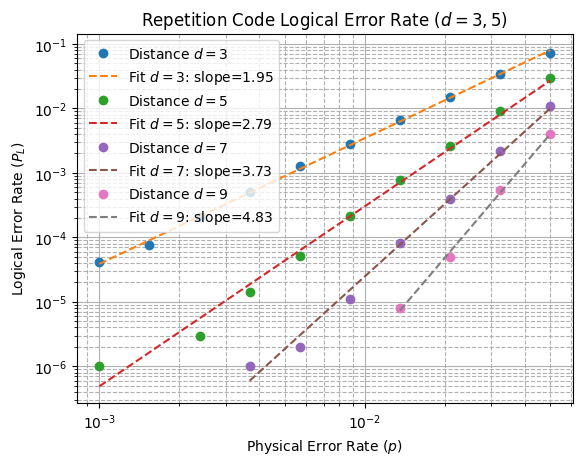

In [ ]:
import stim
import pymatching
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_rep_code_simple_d3_d5():
    """
    Manually simulates and plots rep code data for d=3 and d=5
    using a FIXED number of shots for every point.
    """

    # 1. Define the parameters for the simulation
    distances = [3, 5,7,9]  # Only run for d=3 and d=5
    num_rounds = 9     # num_rounds just needs to be >= max distance
    noise_levels = np.logspace(np.log10(0.001), np.log10(0.05), 10)

    # --- Simulation Loop Parameters ---
    # We will run this many shots for EVERY (d, p) point.
    FIXED_SHOTS_PER_POINT = 1_000_000 
    
    # Store our final results (p, P_L) for each distance
    all_plot_data = {}

    print(f"--- Starting Simple Simulation (Fixed {FIXED_SHOTS_PER_POINT:,} shots per point) ---")
    
    # 2. Loop over all parameters
    for d in distances:
        print(f"\nStarting Distance d={d}...")
        
        # Store (x, y) coordinates for this distance's line
        plot_points = {'x': [], 'y': []}
        
        for p in noise_levels:
            start_time = time.time()
            
            # A. Get the circuit, error model, and decoder
            circuit = stim.Circuit.generated(
                "repetition_code:memory",
                distance=d,
                rounds=num_rounds,
                after_clifford_depolarization=p
            )
            dem = circuit.detector_error_model(decompose_errors=True)
            decoder = pymatching.Matching.from_detector_error_model(dem)
            sampler = circuit.compile_detector_sampler()

            # B. Sample ONE big batch
            detection_events, logical_observables = sampler.sample(
                shots=FIXED_SHOTS_PER_POINT,
                separate_observables=True
            )
            
            # C. Decode the batch
            predicted_observables = decoder.decode_batch(detection_events)
            
            # D. Count errors
            total_errors = np.sum(                                                                          
                np.any(predicted_observables != logical_observables, axis=1)
            )
            total_shots = FIXED_SHOTS_PER_POINT

            # E. Store the final statistic for this (d, p) point
            logical_error_rate = total_errors / total_shots
            
            if total_errors > 0: # Only plot points where we saw at least one error
                plot_points['x'].append(p)
                plot_points['y'].append(logical_error_rate)

            end_time = time.time()
            print(f"  p={p:.4f}: P_L={logical_error_rate:.2e} ({total_errors} errors / {total_shots} shots) [{(end_time-start_time):.2f}s]")

        # Save the line for this distance
        all_plot_data[d] = plot_points

    print("\n--- Simulation Complete. Plotting... ---")

    # 3. Plot the results
    fig, ax = plt.subplots(1, 1)

    for d, data in all_plot_data.items():
        x = np.array(data['x'])
        y = np.array(data['y'])
        
        # Plot data points
        ax.plot(x, y, 'o', label=f"Distance $d={d}$")
        
        # --- Perform linear fit in log–log space ---
        logx = np.log10(x)
        logy = np.log10(y)
        
        # Fit a straight line: log10(P_L) = a * log10(p) + b
        coeffs = np.polyfit(logx, logy, 1)
        a, b = coeffs
        print(f"d={d}: log-log slope = {a:.2f}, intercept = {b:.2f}")
        
        # Create fitted line (convert back to normal scale)
        y_fit = 10**(a * logx + b)
        
        ax.plot(x, y_fit, '--', label=f"Fit $d={d}$: slope={a:.2f}")

    # --- Configure the log–log plot ---
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Repetition Code Logical Error Rate ($d=3,5$)")
    ax.set_xlabel("Physical Error Rate ($p$)")
    ax.set_ylabel("Logical Error Rate ($P_L$)")
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.legend()

    plt.show()

plot_rep_code_simple_d3_d5()

## Rep Code w/Sinter

In [1]:
import sinter_file

In [2]:
import numpy as np
distances = [3,5]
physerrorprobs = np.logspace(-3, -1.5, 6)

In [3]:
samples = sinter_file.run_sinter_simulation_rep_code(
    distances=distances,
    p_values=physerrorprobs,
    num_rounds=5)


Starting 12 workers...


Generated 12 tasks.
--- Starting sinter.collect ---


12 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                      
        1 pymatching <1m    9942383         499 d=3,p=0.001,rounds=5               
        1 pymatching   ?   10000000         500 d=3,p=0.001995262314968879,rounds=5
        1 pymatching   ?   10000000         500 d=3,p=0.003981071705534973,rounds=5
        1 pymatching   ?   10000000         500 d=3,p=0.007943282347242814,rounds=5
        1 pymatching   ?   10000000         500 d=3,p=0.015848931924611134,rounds=5
        1 pymatching   ?   10000000         500 d=3,p=0.03162277660168379,rounds=5 
        1 pymatching   ?   10000000         500 d=5,p=0.001,rounds=5               
        1 pymatching   ?   10000000         500 d=5,p=0.001995262314968879,rounds=5
        1 pymatching   ?   10000000         500 d=5,p=0.003981071705534973,rounds=5
        1 pymatching   ?   10000000         500 d=5,p=0.007943282347242814,rounds=5
        1 pymatching   ?   10000000         500 d=5,p=0.01584


--- Sinter finished successfully in 2.08s ---


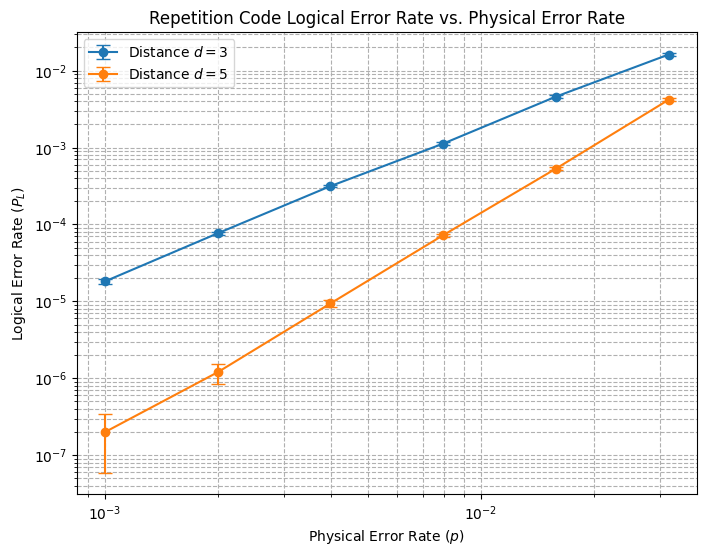

In [4]:
sinter_file.sinter_plot(samples,distances, "Repetition Code", errorbars=True)

## Bacon Shor 

In [5]:
distances = [5]
phys_error_probs = np.logspace(np.log10(0.000001), np.log10(0.4), 30)
samples = sinter_file.run_bacon_shor_simulation(phys_error_probs)

detection events [[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False


Starting 12 workers...


detection events [[False  True False False False  True False False False False False  True
  False  True False False]
 [ True  True  True False False  True False  True  True  True False  True
   True False False  True]
 [ True  True False False False  True False False  True False False  True
  False  True False  True]
 [False False False False False False  True  True False  True False  True
  False False False False]
 [ True  True False False False False  True False False False False False
   True  True  True  True]
 [ True  True  True  True  True  True  True False  True  True False False
  False False  True False]
 [ True  True  True  True False  True False False  True  True False  True
   True False False False]
 [ True False False  True False  True  True False  True  True False False
   True  True False False]
 [False  True False False False  True False  True False  True False False
   True  True False False]
 [False False  True  True  True False False False  True False  True False


30 tasks left:
  workers    decoder eta shots_left errors_left json_metadata               
        1 pymatching   ?  100000000         500 d=5,p=1e-06                 
        1 pymatching   ?  100000000         500 d=5,p=1.560179195630285e-06 
        1 pymatching   ?  100000000         500 d=5,p=2.434159122477563e-06 
        1 pymatching   ?  100000000         500 d=5,p=3.7977244217431575e-06
        1 pymatching   ?  100000000         500 d=5,p=5.925130633540729e-06 
        1 pymatching <1m   99958767         491 d=5,p=9.244265545841936e-06 
        1 pymatching   ?  100000000         500 d=5,p=1.44227107835044e-05  
        1 pymatching   ?  100000000         500 d=5,p=2.2502013309016133e-05
        1 pymatching   ?  100000000         500 d=5,p=3.510717302452276e-05 
        1 pymatching   ?  100000000         500 d=5,p=5.477348097025316e-05 
        1 pymatching   ?  100000000         500 d=5,p=8.54564454820403e-05  
        1 pymatching   ?  100000000         500 d=5,p=0.00013


--- Sinter finished successfully in 2.26s ---


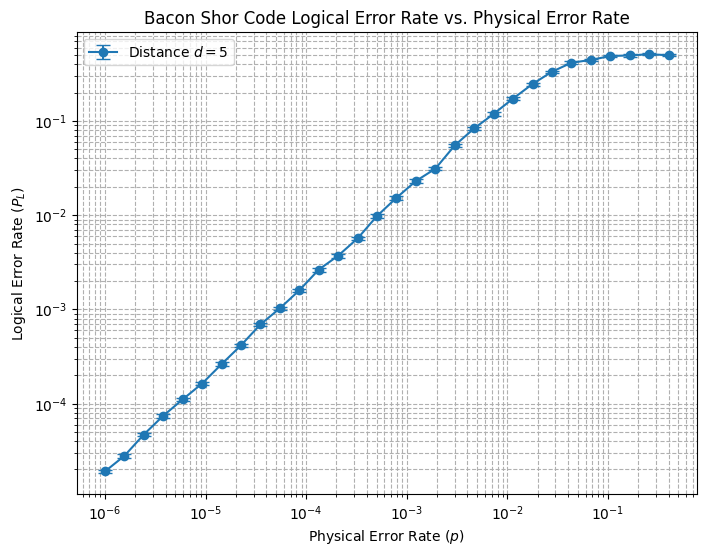

In [6]:
sinter_file.sinter_plot(samples,5, "Bacon Shor Code", errorbars=True)